## Rolling Cross Validation for Monthly CPI Forecasting

In this notebook, using Prophet, we provide a template for a rolling cross validation experiment on a CPI forecasting task. The purpose of rolling cross validation, in this context, is to evaluate how well the strategy of consuming all available data for model training would have worked in retrospect. This can be useful in situations where data are scarce and where it is desirable to train models using the most recently available data possible.

To do this, we will refit a Prophet model using data up to several cutoff dates. In this notebook, we use 6 cutoff dates that are all one year apart. This code has been adapted from Vector's contribution to the 2022 edition of Canada's Food Price Report, with code available [here](https://github.com/VectorInstitute/foodprice-forecasting).

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
pd.set_option('display.precision', 3)
from prophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import os

In [3]:
"""
Set the output path corresponding to the experiment. The ensembling experiment will
look for specific output files in the output directory corresponding to forecasts,
e.g.: ./output/prophet_202110/forecasts_2015-07-01.csv
"""
output_path = "./rolling_cv_output/prophet_experiment"
if not os.path.exists(output_path):
    if not os.path.exists("./rolling_cv_output"):
        os.mkdir("./rolling_cv_output")
    os.mkdir(output_path)

## Load Data From File

In this demo, we will use Prophet to produce univarate forecasts for each of the 9 major Canadian food price categories listed in the columns below. The dataset is part of a larger dataset that includes many variables from the [FRED](https://fred.stlouisfed.org/) database. These variables are not used in this demo, but could certainly be used in an exploration of more sophisticated global or multivariate forecasting models!

If we're using Colab, we mount our Google Drive which should have the bootcamp datasets in it already (See Github Repo Readme for instructions).

In [4]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


`data_dir` should be changed to reflect the address of the cpi_forecasting dataset. For example, if using Colab, the dataset may be housed in `/content/drive/MyDrive/Forecasting Bootcamp`.

In [6]:
data_dir = "/content/drive/MyDrive/bootcamp_datasets/cpi_forecasting"

# Read food price categories from the text file
with open(f"{data_dir}/foodprice_categories.txt", "r") as file:
    foodprice_categories = file.read().splitlines()

# Read the main data file
foodprice_df = pd.read_csv(f"{data_dir}/all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

Bakery and cereal products (excluding baby food)  \
1986-01-01                                              69.3   
1986-02-01                                              70.3   
1986-03-01                                              70.6   
1986-04-01                                              71.3   
1986-05-01                                              71.2   
...                                                      ...   
2021-06-01                                             157.7   
2021-07-01                                             157.9   
2021-08-01                                             158.5   
2021-09-01                                             158.1   
2021-10-01                                             159.3   

            Dairy products and eggs  Fish, seafood and other marine products  \
1986-01-01                     70.9                                     60.6   
1986-02-01                     70.8                                     61.3   
1986-03-01                     71.1                                     61.3   
1986-04-01                     71.0                                     61.4   
1986-05-01                     71.4                                     61.9   
...                             ...                                      ...   
2021-06-01                    145.3                                    146.2   
2021-07-01                    146.4                                    146.6   
2021-08-01                    148.3                                    146.8   
2021-09-01                    148.0                                    147.1   
2021-10-01                    146.6                                    149.3   

            Food purchased from restaurants   Food  \
1986-01-01                             59.1   67.3   
1986-02-01                             59.1   66.9   
1986-03-01                             59.3   67.0   
1986-04-01                             59.7   67.7   
1986-05-01                             59.9   68.2   
...                                     ...    ...   
2021-06-01                            163.9  156.8   
2021-07-01                            165.2  157.6   
2021-08-01                            165.9  158.0   
2021-09-01                            165.9  158.5   
2021-10-01                            167.1  159.2   

            Fruit, fruit preparations and nuts   Meat  \
1986-01-01                                76.0   65.1   
1986-02-01                                77.6   64.2   
1986-03-01                                79.2   64.2   
1986-04-01                                82.2   63.6   
1986-05-01                                83.5   64.0   
...                                        ...    ...   
2021-06-01                               144.5  176.7   
2021-07-01                               141.7  180.9   
2021-08-01                               142.5  182.1   
2021-09-01                               141.5  184.8   
2021-10-01                               141.7  187.1   

            Other food products and non-alcoholic beverages  \
1986-01-01                                             77.5   
1986-02-01                                             78.1   
1986-03-01                                             78.6   
1986-04-01                                             79.5   
1986-05-01                                             79.8   
...                                                     ...   
2021-06-01                                            142.2   
2021-07-01                                            141.9   
2021-08-01                                            141.7   
2021-09-01                                            144.3   
2021-10-01                                            144.4   

            Vegetables and vegetable preparations  DEXCAUS  ...  \
1986-01-01                                   76.0    1.392  ...   
1986-02-01                                   68.4    1.39

## Experiment Setup

Load the rolling cross validation cutoff dates specified in a file.

In [12]:
# Read cutoff dates from the text file
with open(f"{data_dir}/cutoff_dates.txt", "r") as file:
    cutoff_dates = file.read().splitlines()

# Convert the dates to pandas Timestamp objects
cutoff_dates = pd.to_datetime(cutoff_dates)

# Display the list of cutoff dates
cutoff_dates

DatetimeIndex(['2015-07-01', '2016-07-01', '2017-07-01', '2018-07-01',
               '2019-07-01', '2020-07-01'],
              dtype='datetime64[ns]', freq=None)

Use the cutoff dates to determine collections of training and validation periods that correspond to the cutoff date. In this case, the task is to train using all data available up to the cutoff date, and to evaluate forecasts on the following 18 months only. This is a direct reflection of this specific use case, where we are only ever interested in producing 18-month forecasts on an annual basis.

In [13]:
sim_train_dates = {}
sim_valid_dates = {}

for date in cutoff_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

### Helper Function for Prophet Data Loading

In [14]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', 'index':'ds', food_category:'y'}, axis=1)
    return df

### Define Evaluation Metrics

In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

## Define Functions to Fit and Evaluate Models for All CPI Categories (Validation)

The following function will fit and evaluate a Prophet model for a single food price category using the specified training and validation dates

In [16]:
def fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates):
    train_df = get_prophet_df(foodprice_df, food_category, train_dates)     # Select training data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    valid_df = get_prophet_df(foodprice_df, food_category, valid_dates)     # Select the validation data.
    valid_forecast = model.predict(valid_df[['ds']])                        # Produce the validation period forecast.

    valid_metrics = {metric_name: metric_fn(y_true=valid_df.y,              # Compute validation metrics.
                                      y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

    return model, valid_forecast, valid_metrics

In [17]:
def plot_valid_forecast(model, food_category, sim_forecast_date, valid_forecast, valid_actual):

    fig = model.plot(valid_forecast, figsize=(10,4))
    ax = fig.axes[0]
    ax.scatter(valid_actual.ds, valid_actual.y, color='green', s=10, label='Actual CPI')
    ax.set_title(f'CPI Forecast (Simulated From {date}) - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.png", bbox_inches='tight')
    plt.show()

### Run model fitting and evaluation

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/q02bjdu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/q5mx9mo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60071', 'data', 'file=/tmp/tmp7f_z_j0i/q02bjdu1.json', 'init=/tmp/tmp7f_z_j0i/q5mx9mo7.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelk7brjalz/prophet_model-20230802195052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


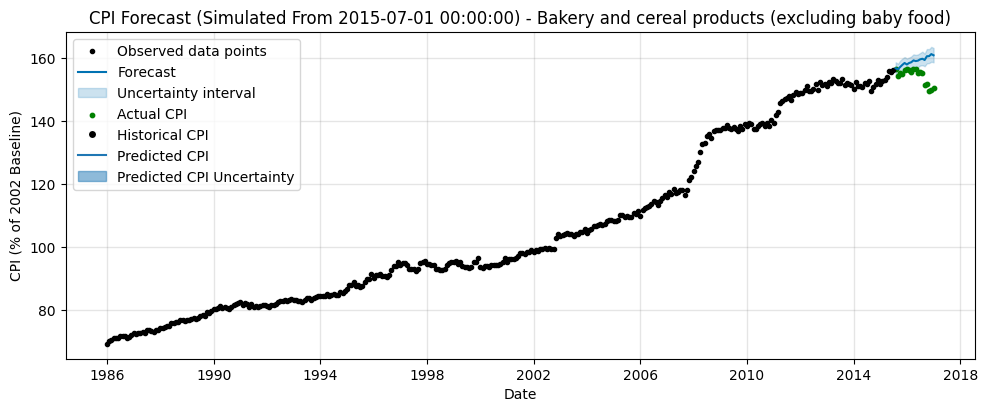

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/bm_apti8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/qasuqs6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59155', 'data', 'file=/tmp/tmp7f_z_j0i/bm_apti8.json', 'init=/tmp/tmp7f_z_j0i/qasuqs6a.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modele30agcll/prophet_model-20230802195054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score    -4.822
mae          4.653
mape         0.031
mse         33.645
rmse         5.800
dtype: float64


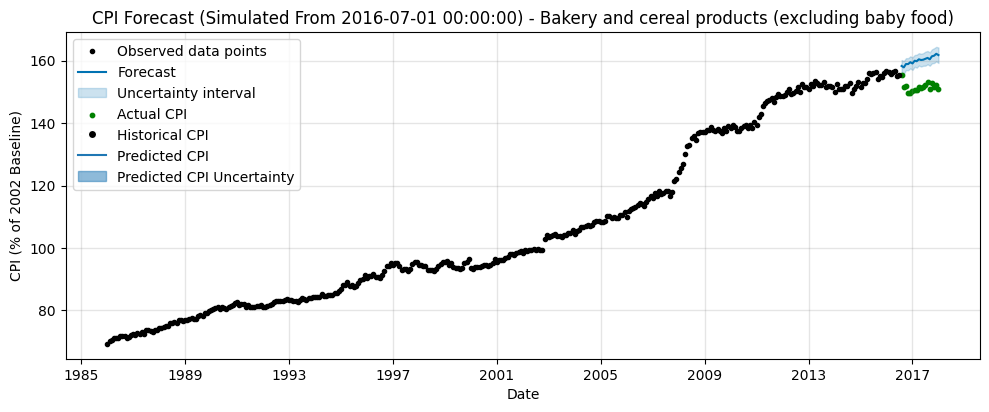

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/354aso93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/vown1mo6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42138', 'data', 'file=/tmp/tmp7f_z_j0i/354aso93.json', 'init=/tmp/tmp7f_z_j0i/vown1mo6.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelfnsvk_5v/prophet_model-20230802195056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score   -43.735
mae          8.556
mape         0.057
mse         76.110
rmse         8.724
dtype: float64


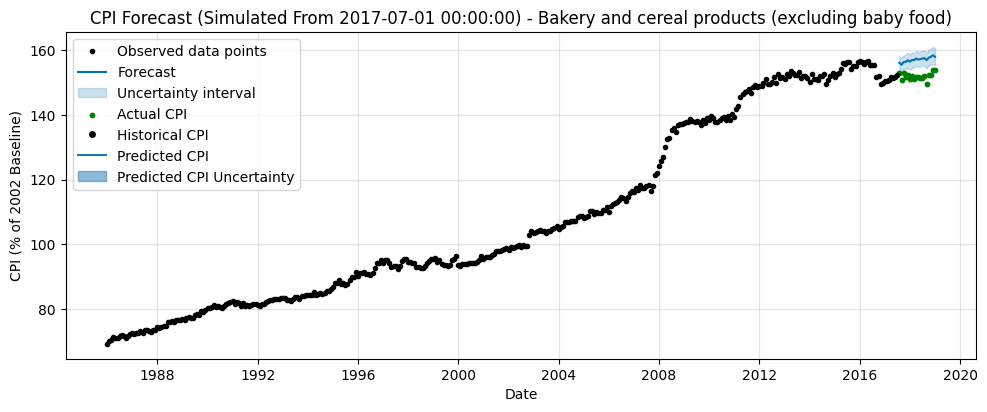

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/xzvwvtms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/t82bi_7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75658', 'data', 'file=/tmp/tmp7f_z_j0i/xzvwvtms.json', 'init=/tmp/tmp7f_z_j0i/t82bi_7e.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model7tsfcn7_/prophet_model-20230802195057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -25.066
mae          5.099
mape         0.034
mse         26.958
rmse         5.192
dtype: float64


19:50:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


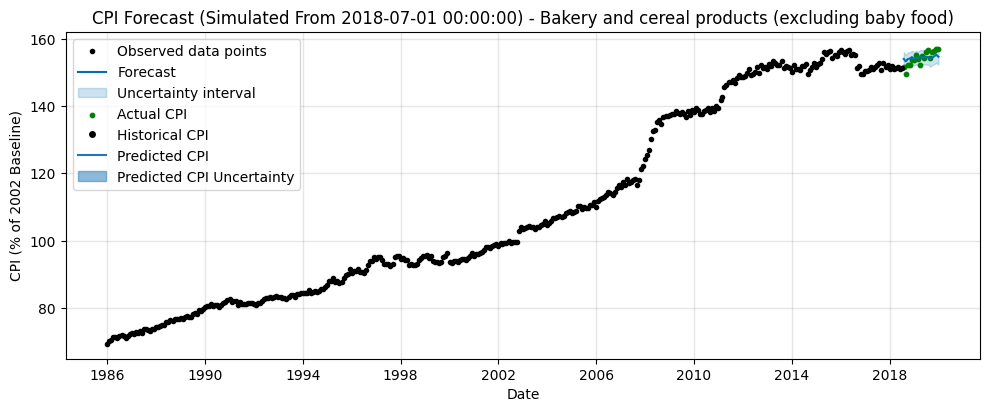

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/ftxz8w0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/upmzvzaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4756', 'data', 'file=/tmp/tmp7f_z_j0i/ftxz8w0s.json', 'init=/tmp/tmp7f_z_j0i/upmzvzaq.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modeltwbm3tai/prophet_model-20230802195100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.277
mae         1.408
mape        0.009
mse         2.887
rmse        1.699
dtype: float64


19:51:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


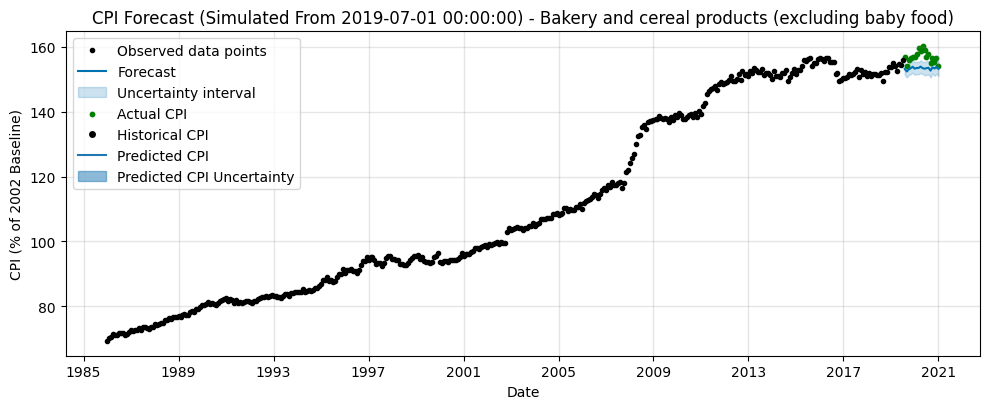

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/o_j8rvku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/dan0et4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71290', 'data', 'file=/tmp/tmp7f_z_j0i/o_j8rvku.json', 'init=/tmp/tmp7f_z_j0i/dan0et4n.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelm3v5zp_l/prophet_model-20230802195103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -4.506
mae          3.587
mape         0.023
mse         15.091
rmse         3.885
dtype: float64


19:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


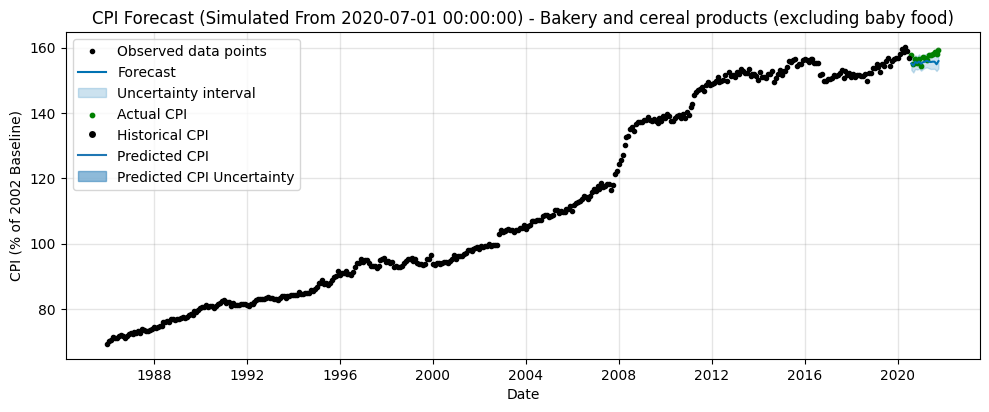

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/z7ne6vye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/i1ue_s6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7199', 'data', 'file=/tmp/tmp7f_z_j0i/z7ne6vye.json', 'init=/tmp/tmp7f_z_j0i/i1ue_s6d.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model7m8j7jzg/prophet_model-20230802195104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -1.144
mae         1.667
mape        0.011
mse         3.892
rmse        1.973
dtype: float64


19:51:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


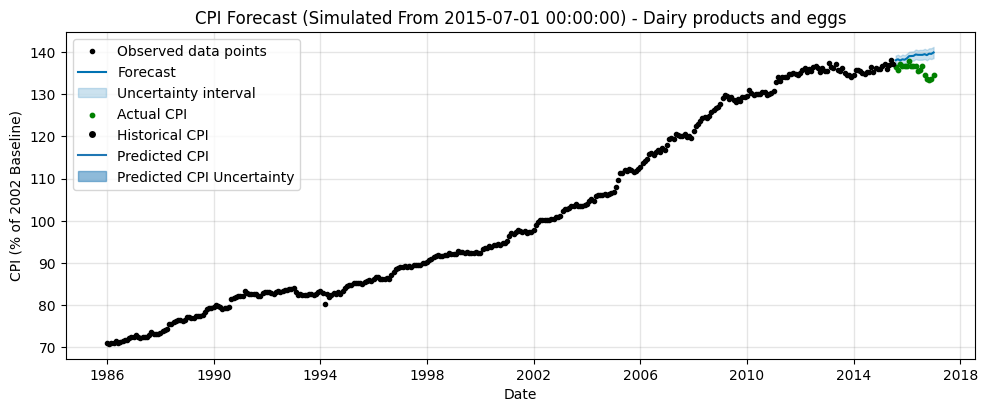

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/1uyrkjsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/p7tpwx36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11715', 'data', 'file=/tmp/tmp7f_z_j0i/1uyrkjsx.json', 'init=/tmp/tmp7f_z_j0i/p7tpwx36.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_models10mvefi/prophet_model-20230802195106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -6.643
mae          3.148
mape         0.023
mse         12.866
rmse         3.587
dtype: float64


19:51:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


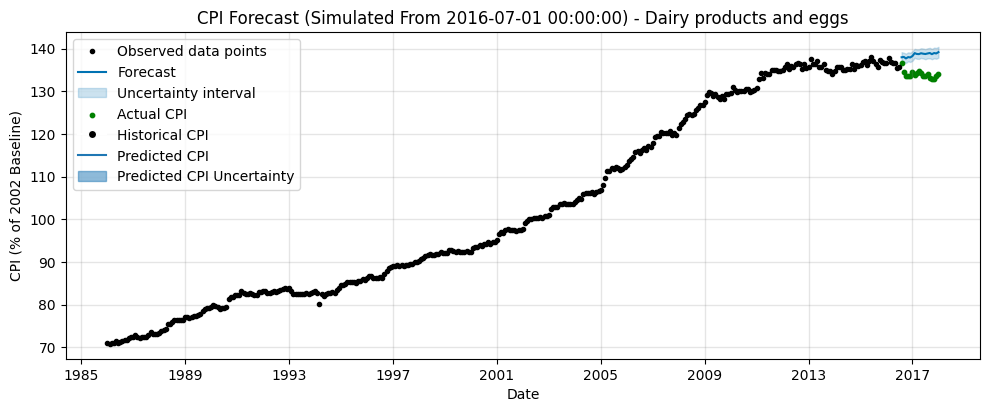

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/x9zk6f1k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/g1na1yu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98191', 'data', 'file=/tmp/tmp7f_z_j0i/x9zk6f1k.json', 'init=/tmp/tmp7f_z_j0i/g1na1yu2.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelafgkz0hm/prophet_model-20230802195108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -29.866
mae          4.629
mape         0.035
mse         22.608
rmse         4.755
dtype: float64


19:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


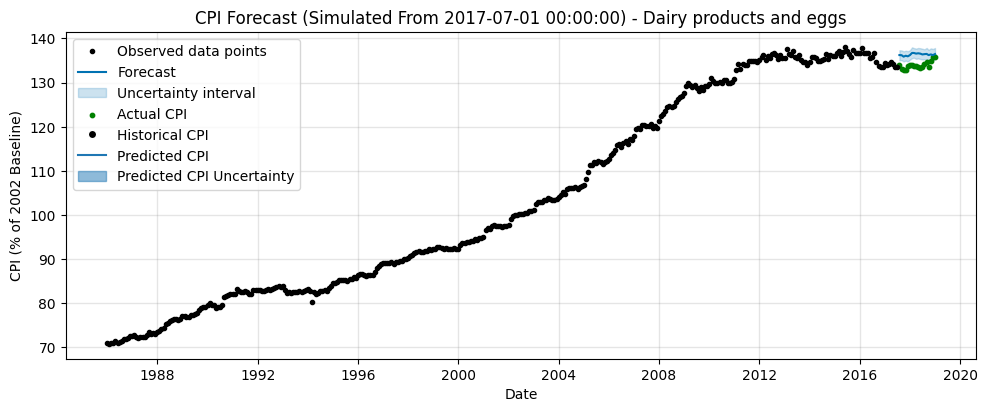

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/c82dux91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/pwpzxk9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49261', 'data', 'file=/tmp/tmp7f_z_j0i/c82dux91.json', 'init=/tmp/tmp7f_z_j0i/pwpzxk9t.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelf7hqj3wu/prophet_model-20230802195110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -8.021
mae         2.391
mape        0.018
mse         6.375
rmse        2.525
dtype: float64


19:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


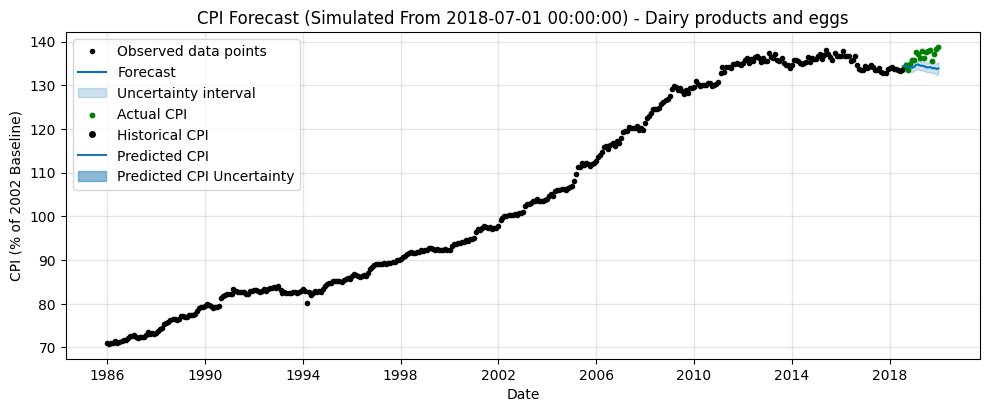

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/dtck5k2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/pm27hpb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8631', 'data', 'file=/tmp/tmp7f_z_j0i/dtck5k2l.json', 'init=/tmp/tmp7f_z_j0i/pm27hpb8.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modeluh420up0/prophet_model-20230802195112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -2.502
mae         2.373
mape        0.017
mse         7.726
rmse        2.780
dtype: float64


19:51:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


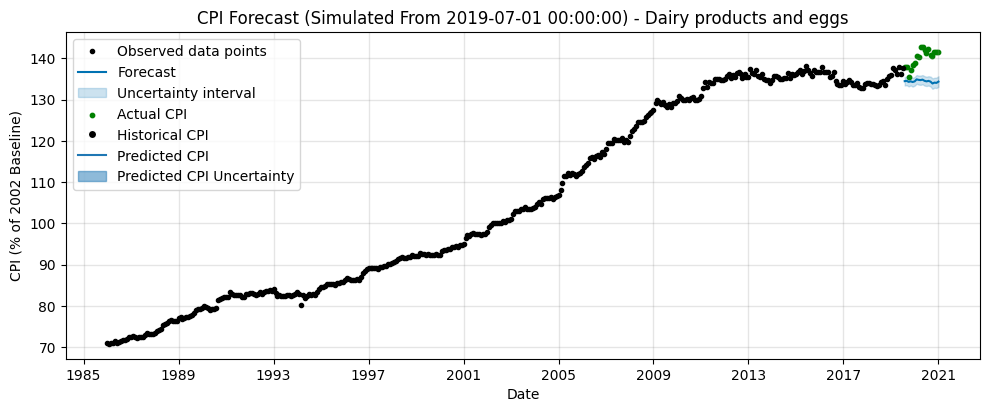

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/lfvrzbho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/7e55swfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32222', 'data', 'file=/tmp/tmp7f_z_j0i/lfvrzbho.json', 'init=/tmp/tmp7f_z_j0i/7e55swfl.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model9_32ozgi/prophet_model-20230802195114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -7.823
mae          5.749
mape         0.041
mse         37.121
rmse         6.093
dtype: float64


19:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


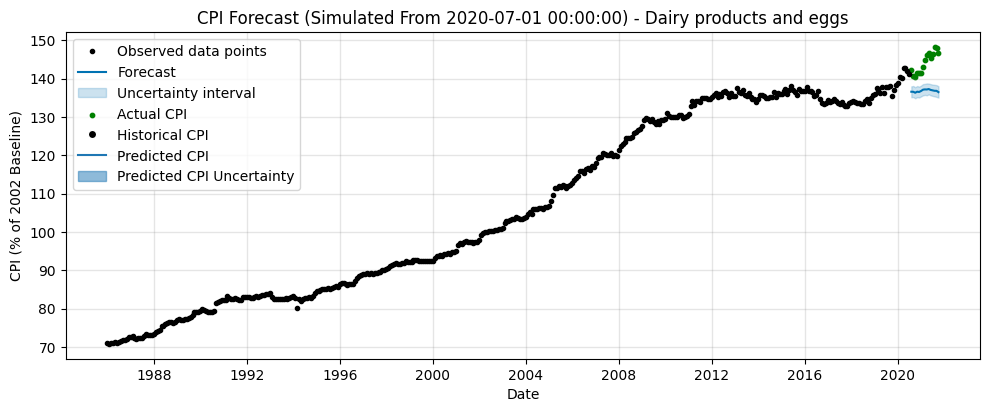

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/xzl69n1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/j4drmnxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29164', 'data', 'file=/tmp/tmp7f_z_j0i/xzl69n1n.json', 'init=/tmp/tmp7f_z_j0i/j4drmnxp.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelvh64hq9r/prophet_model-20230802195117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -7.844
mae          7.416
mape         0.051
mse         61.188
rmse         7.822
dtype: float64


19:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


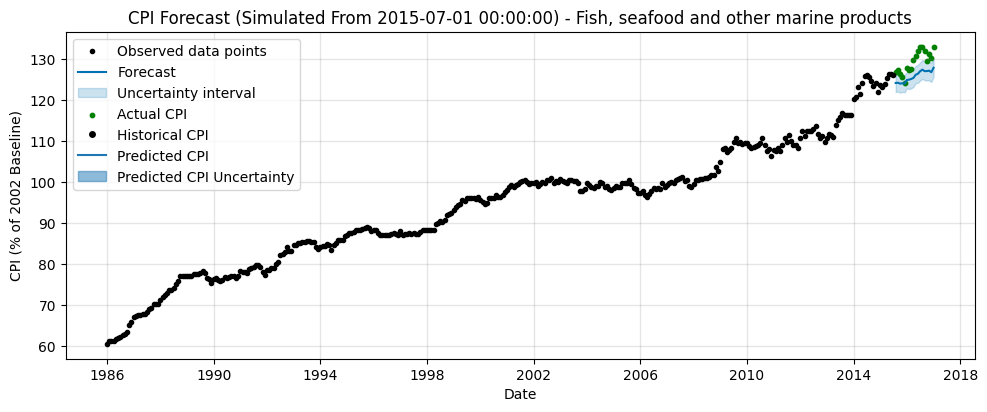

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/s95jvljs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/e5wvnq12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57291', 'data', 'file=/tmp/tmp7f_z_j0i/s95jvljs.json', 'init=/tmp/tmp7f_z_j0i/e5wvnq12.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modeleu7zeu26/prophet_model-20230802195119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -1.023
mae          3.493
mape         0.027
mse         14.548
rmse         3.814
dtype: float64


19:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


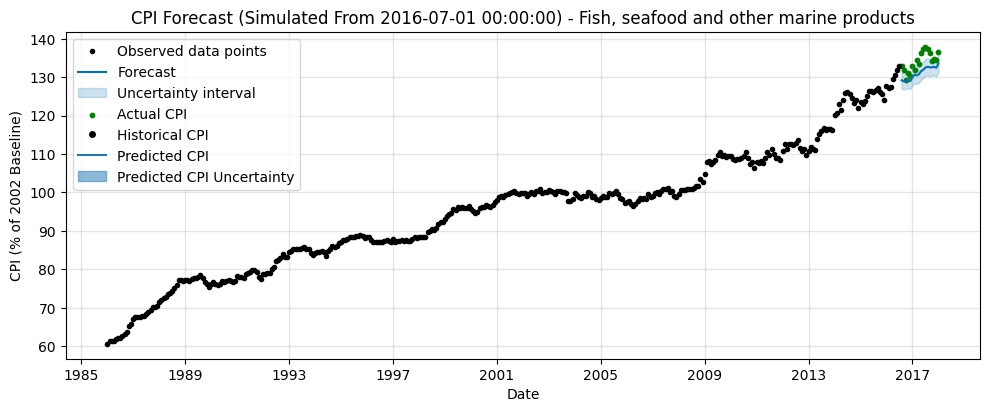

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/koisrjgn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/gzod0fv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82770', 'data', 'file=/tmp/tmp7f_z_j0i/koisrjgn.json', 'init=/tmp/tmp7f_z_j0i/gzod0fv4.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelvfwygerm/prophet_model-20230802195121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -0.812
mae          2.994
mape         0.022
mse         11.006
rmse         3.318
dtype: float64


19:51:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


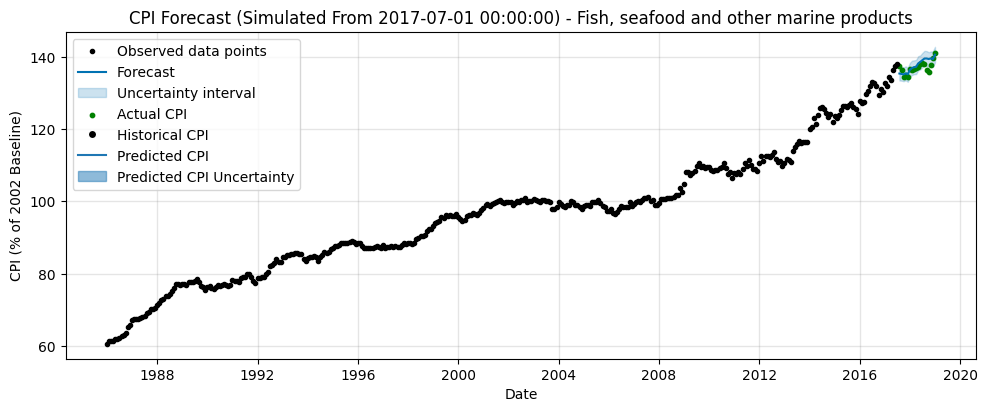

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/3mjne23y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/90v92v7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80570', 'data', 'file=/tmp/tmp7f_z_j0i/3mjne23y.json', 'init=/tmp/tmp7f_z_j0i/90v92v7k.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelbcl2opyy/prophet_model-20230802195123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.227
mae         1.082
mape        0.008
mse         2.082
rmse        1.443
dtype: float64


19:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


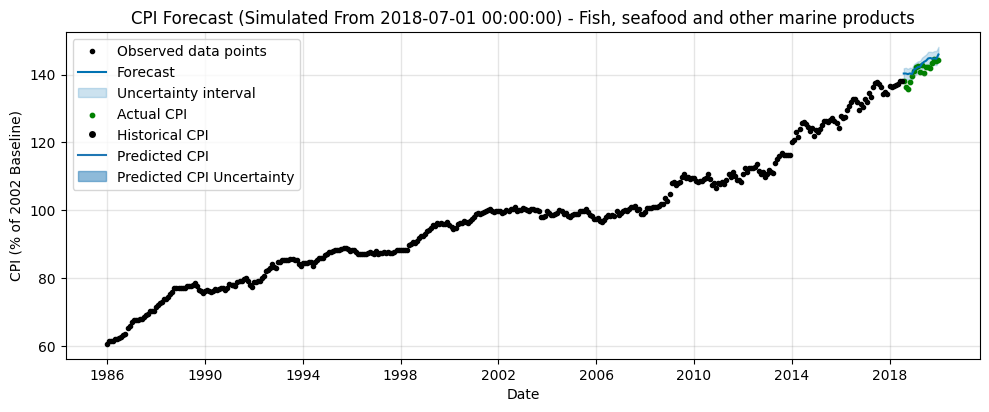

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/wiau0w4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/ezndynf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92084', 'data', 'file=/tmp/tmp7f_z_j0i/wiau0w4g.json', 'init=/tmp/tmp7f_z_j0i/ezndynf8.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelgz8luo51/prophet_model-20230802195124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.282
mae         1.749
mape        0.013
mse         4.710
rmse        2.170
dtype: float64


19:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


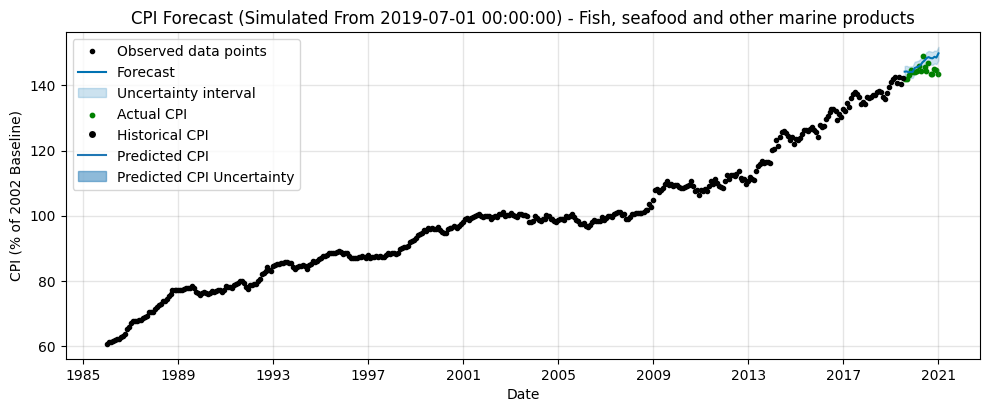

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/doagfu8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/rafn19fx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43733', 'data', 'file=/tmp/tmp7f_z_j0i/doagfu8e.json', 'init=/tmp/tmp7f_z_j0i/rafn19fx.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelzhlvod6j/prophet_model-20230802195126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score   -2.420
mae         2.422
mape        0.017
mse         8.912
rmse        2.985
dtype: float64


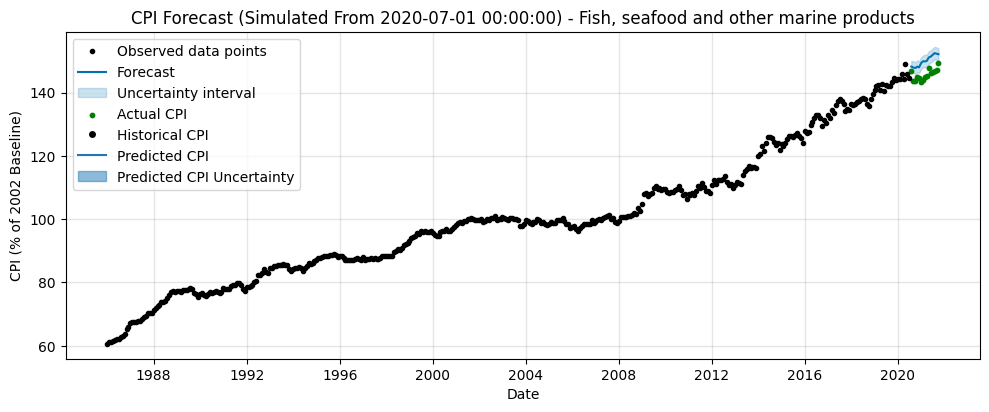

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/7akva3_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/fj2wmios.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72882', 'data', 'file=/tmp/tmp7f_z_j0i/7akva3_8.json', 'init=/tmp/tmp7f_z_j0i/fj2wmios.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelakfpw2wi/prophet_model-20230802195128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -6.321
mae          4.360
mape         0.030
mse         20.604
rmse         4.539
dtype: float64


19:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


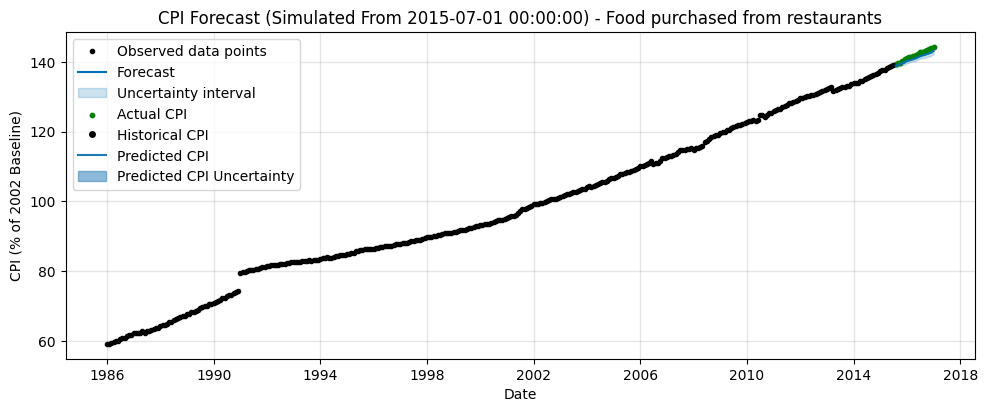

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/mw3b9f51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/hvc6bfpg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76875', 'data', 'file=/tmp/tmp7f_z_j0i/mw3b9f51.json', 'init=/tmp/tmp7f_z_j0i/hvc6bfpg.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelv3xvhows/prophet_model-20230802195131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.550
mae         0.971
mape        0.007
mse         1.022
rmse        1.011
dtype: float64


19:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


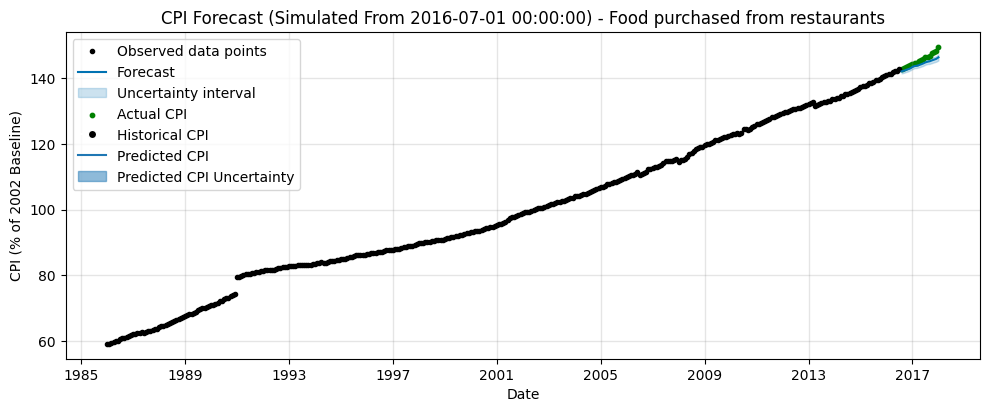

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/zg2knqgv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/_khevk89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54956', 'data', 'file=/tmp/tmp7f_z_j0i/zg2knqgv.json', 'init=/tmp/tmp7f_z_j0i/_khevk89.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelzddhi08n/prophet_model-20230802195133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.297
mae         1.429
mape        0.010
mse         2.456
rmse        1.567
dtype: float64


19:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


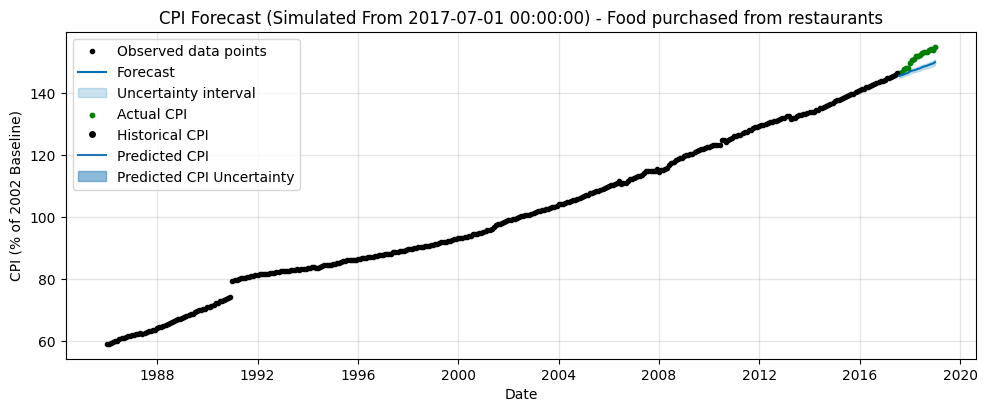

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/h1osocxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/jdllv_a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73472', 'data', 'file=/tmp/tmp7f_z_j0i/h1osocxk.json', 'init=/tmp/tmp7f_z_j0i/jdllv_a8.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelcjstmx6a/prophet_model-20230802195135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -1.008
mae          3.467
mape         0.023
mse         13.892
rmse         3.727
dtype: float64


19:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


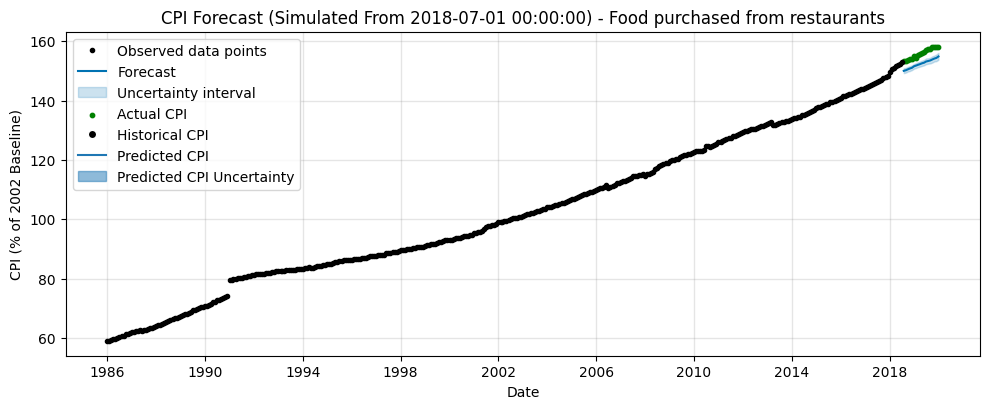

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/ndeuz8p3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/g7w5q2nd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47725', 'data', 'file=/tmp/tmp7f_z_j0i/ndeuz8p3.json', 'init=/tmp/tmp7f_z_j0i/g7w5q2nd.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model1ccxx05y/prophet_model-20230802195138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -3.000
mae          3.434
mape         0.022
mse         11.949
rmse         3.457
dtype: float64


19:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


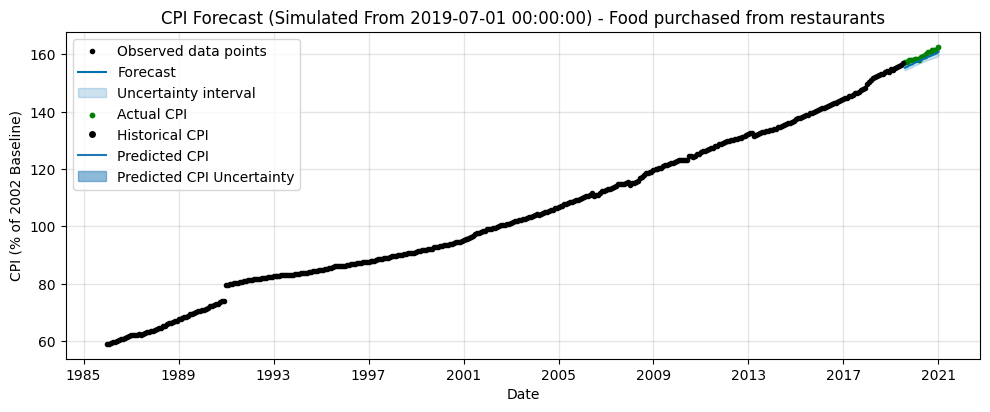

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/6yb08mig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/xls6r0_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76543', 'data', 'file=/tmp/tmp7f_z_j0i/6yb08mig.json', 'init=/tmp/tmp7f_z_j0i/xls6r0_9.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelcvb5sba4/prophet_model-20230802195140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.142
mae         1.448
mape        0.009
mse         2.245
rmse        1.498
dtype: float64


19:51:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


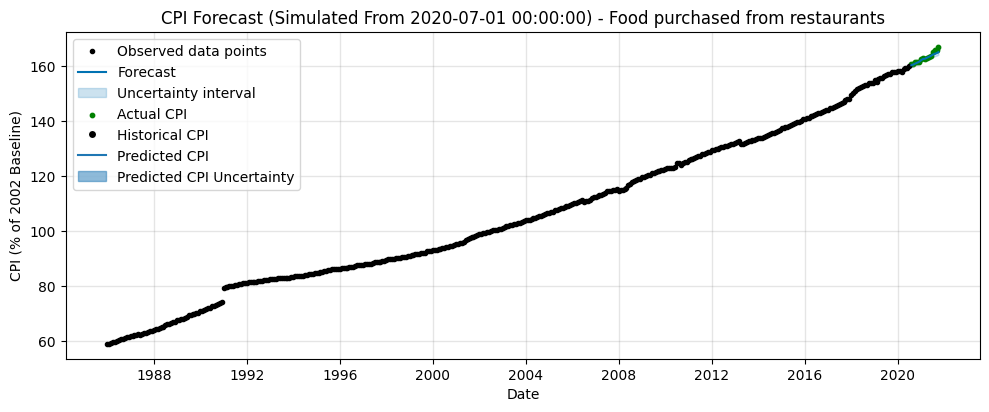

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/5u1a2aj4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/280jt_83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16173', 'data', 'file=/tmp/tmp7f_z_j0i/5u1a2aj4.json', 'init=/tmp/tmp7f_z_j0i/280jt_83.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelh63iis4_/prophet_model-20230802195142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.845
mae         0.511
mape        0.003
mse         0.564
rmse        0.751
dtype: float64


19:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


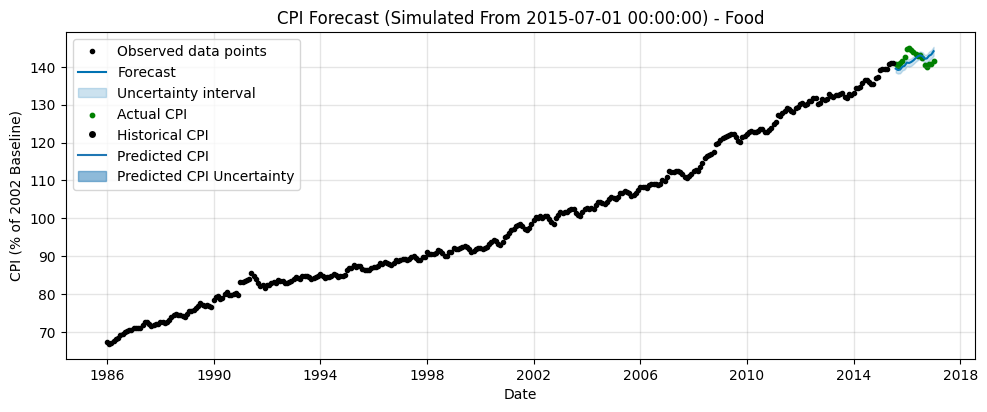

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/zozy6udk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/gufao3j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51883', 'data', 'file=/tmp/tmp7f_z_j0i/zozy6udk.json', 'init=/tmp/tmp7f_z_j0i/gufao3j4.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelakckb9qn/prophet_model-20230802195144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -0.856
mae         1.893
mape        0.013
mse         4.725
rmse        2.174
dtype: float64


19:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


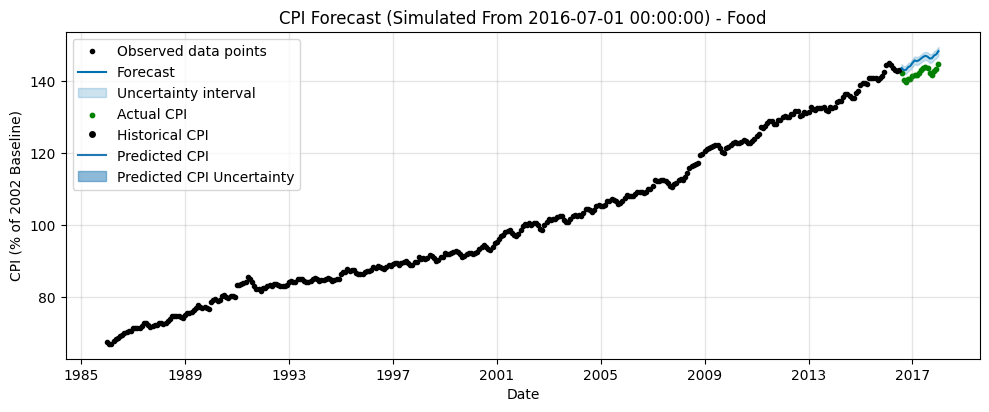

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/i5xxtnq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/q6cb8bsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26184', 'data', 'file=/tmp/tmp7f_z_j0i/i5xxtnq5.json', 'init=/tmp/tmp7f_z_j0i/q6cb8bsq.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model7fzxyyba/prophet_model-20230802195147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -6.406
mae          3.521
mape         0.025
mse         12.889
rmse         3.590
dtype: float64


19:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


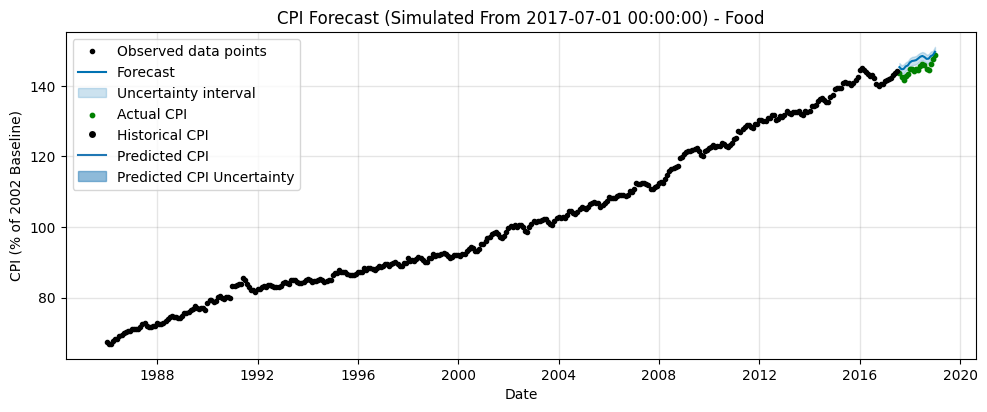

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/h0srpbke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/2cm1t5mu.json
DEBUG:cmdstanpy:idx 0


r2_score   -1.103
mae         2.358
mape        0.016
mse         5.911
rmse        2.431
dtype: float64


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49378', 'data', 'file=/tmp/tmp7f_z_j0i/h0srpbke.json', 'init=/tmp/tmp7f_z_j0i/2cm1t5mu.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modeldiotegoz/prophet_model-20230802195150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


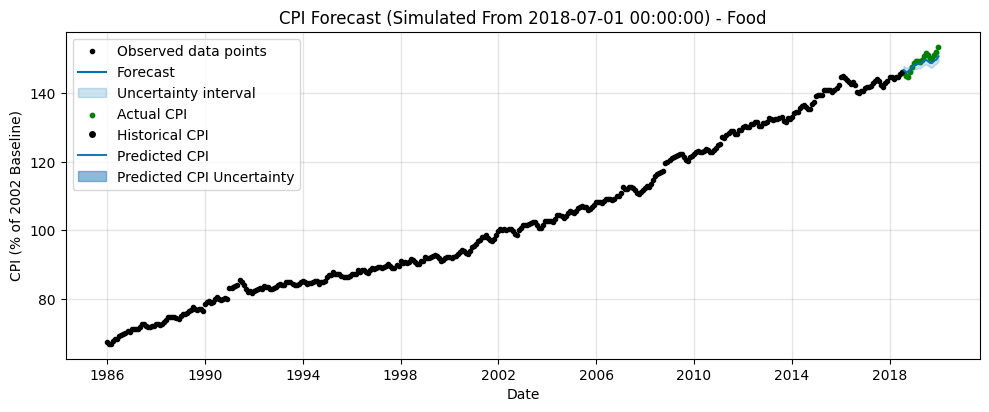

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/1grayn9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/z34f9ac2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63016', 'data', 'file=/tmp/tmp7f_z_j0i/1grayn9_.json', 'init=/tmp/tmp7f_z_j0i/z34f9ac2.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model5hklo66k/prophet_model-20230802195153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.673
mae         1.242
mape        0.008
mse         1.926
rmse        1.388
dtype: float64


19:51:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


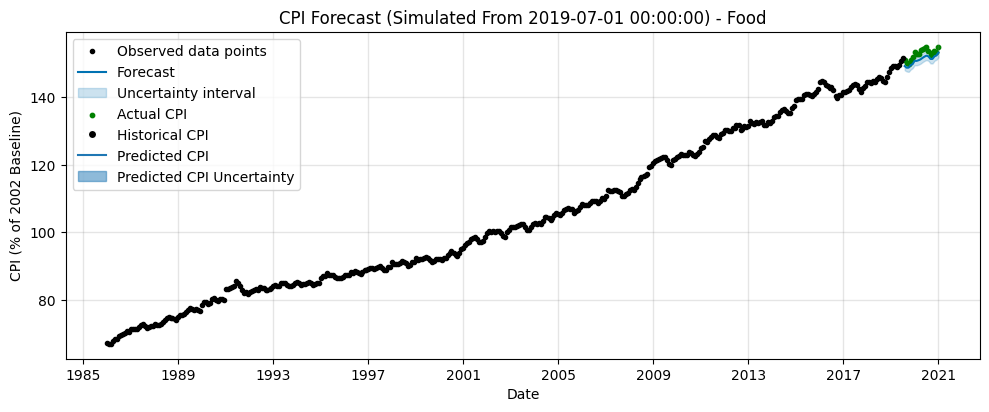

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/82vhj4ah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/6p6w5u_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26381', 'data', 'file=/tmp/tmp7f_z_j0i/82vhj4ah.json', 'init=/tmp/tmp7f_z_j0i/6p6w5u_g.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelu6co_a08/prophet_model-20230802195155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -0.662
mae         1.900
mape        0.012
mse         3.894
rmse        1.973
dtype: float64


19:51:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


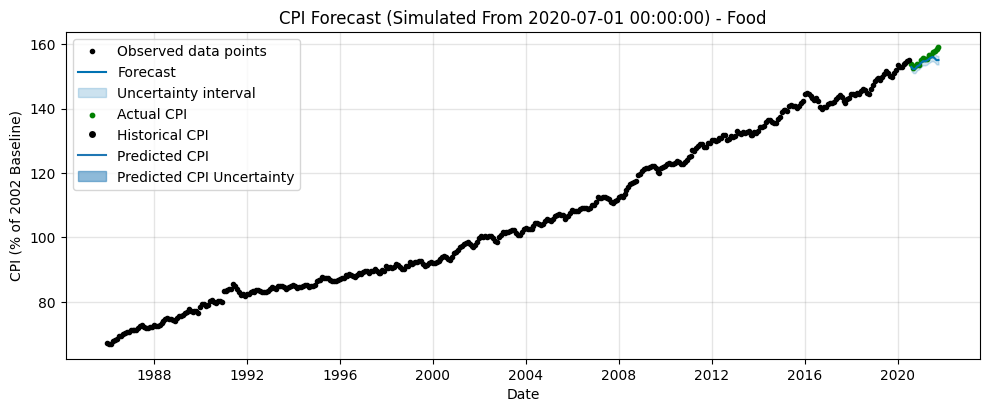

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/brzxpre1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/kc5b_g06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24757', 'data', 'file=/tmp/tmp7f_z_j0i/brzxpre1.json', 'init=/tmp/tmp7f_z_j0i/kc5b_g06.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelgmpmogwq/prophet_model-20230802195157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score    0.255
mae         1.307
mape        0.008
mse         2.893
rmse        1.701
dtype: float64


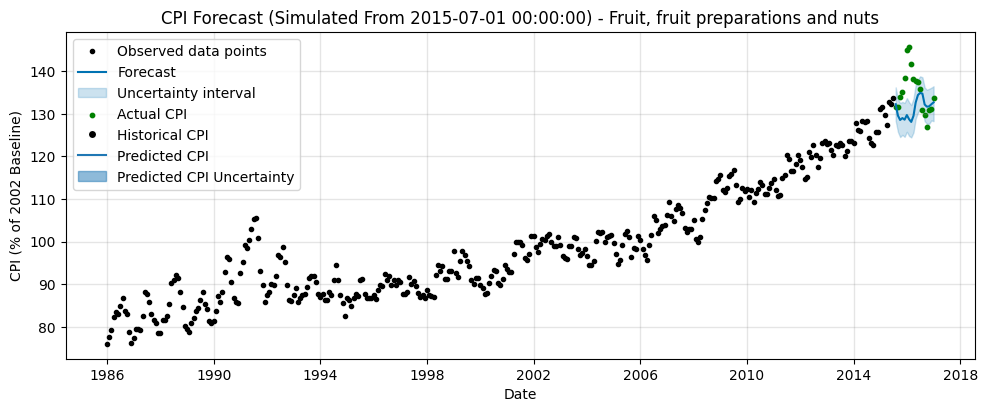

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/bqd863hk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/vicddoq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41389', 'data', 'file=/tmp/tmp7f_z_j0i/bqd863hk.json', 'init=/tmp/tmp7f_z_j0i/vicddoq5.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelpd40jfn5/prophet_model-20230802195159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score    -1.236
mae          5.637
mape         0.041
mse         57.054
rmse         7.553
dtype: float64


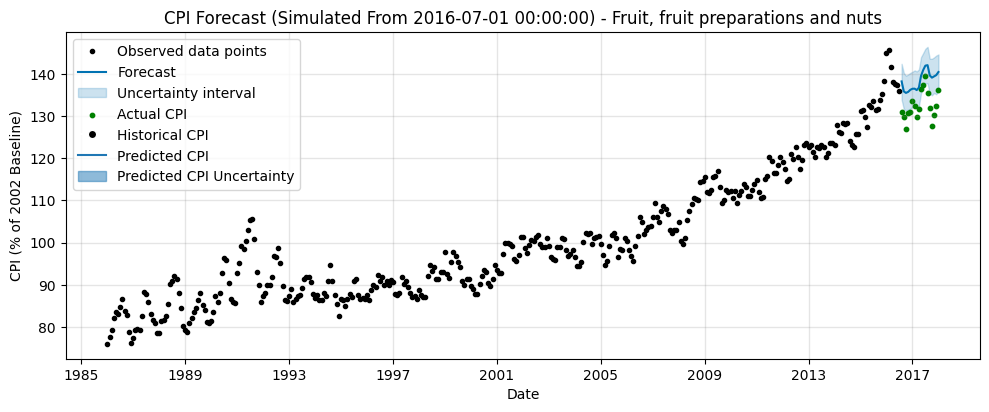

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/uuanp3rs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/r72c73gm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28535', 'data', 'file=/tmp/tmp7f_z_j0i/uuanp3rs.json', 'init=/tmp/tmp7f_z_j0i/r72c73gm.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelbiqfscqw/prophet_model-20230802195201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -2.666
mae          5.878
mape         0.045
mse         40.181
rmse         6.339
dtype: float64


19:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


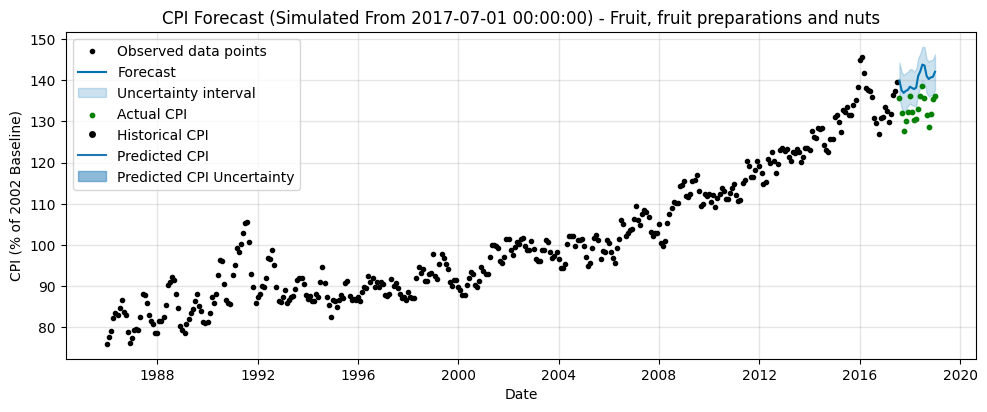

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/im8hpmvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/5n4mypqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47250', 'data', 'file=/tmp/tmp7f_z_j0i/im8hpmvr.json', 'init=/tmp/tmp7f_z_j0i/5n4mypqa.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelc7tfzxnt/prophet_model-20230802195204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score    -4.835
mae          6.835
mape         0.052
mse         51.328
rmse         7.164
dtype: float64


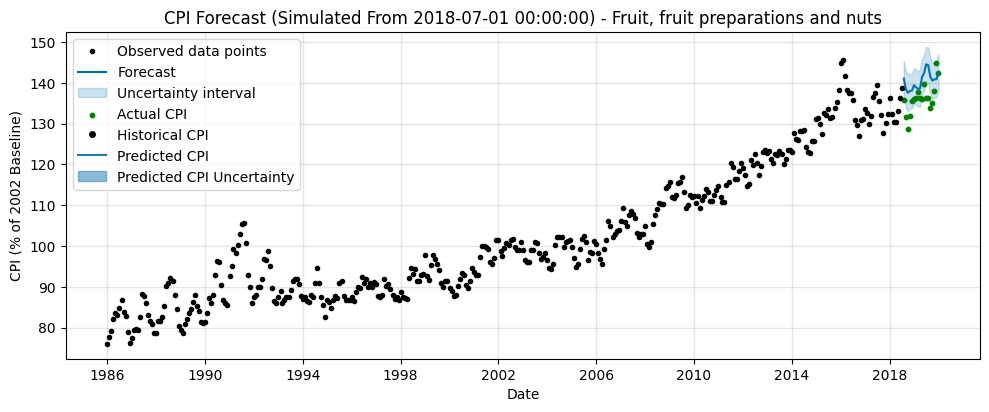

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/tgzj0fjy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/sz1fmiof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37754', 'data', 'file=/tmp/tmp7f_z_j0i/tgzj0fjy.json', 'init=/tmp/tmp7f_z_j0i/sz1fmiof.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelz_q35fpe/prophet_model-20230802195206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score    -1.144
mae          4.655
mape         0.035
mse         28.311
rmse         5.321
dtype: float64


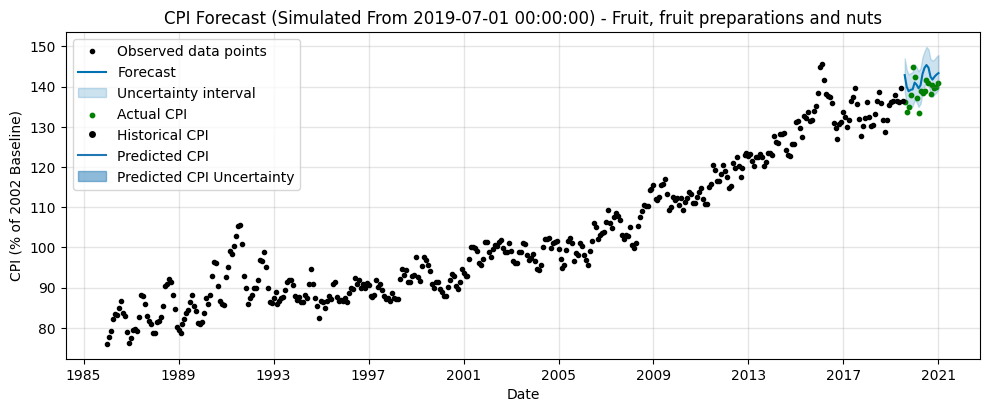

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/2yt6ggzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/361bwasl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72664', 'data', 'file=/tmp/tmp7f_z_j0i/2yt6ggzc.json', 'init=/tmp/tmp7f_z_j0i/361bwasl.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model9vc74cvj/prophet_model-20230802195208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -1.044
mae          3.786
mape         0.027
mse         17.293
rmse         4.158
dtype: float64


19:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


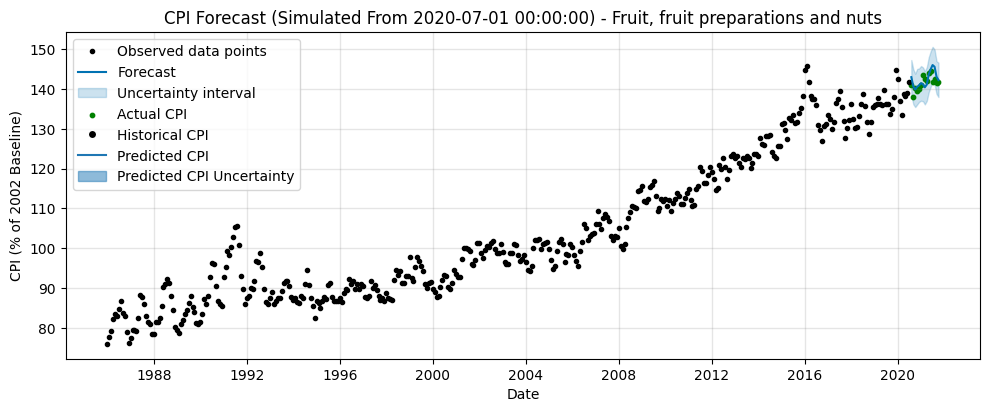

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/l04h6c0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/ayud6qu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13627', 'data', 'file=/tmp/tmp7f_z_j0i/l04h6c0x.json', 'init=/tmp/tmp7f_z_j0i/ayud6qu4.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model42muwajc/prophet_model-20230802195210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -0.350
mae         1.518
mape        0.011
mse         3.597
rmse        1.897
dtype: float64


19:52:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


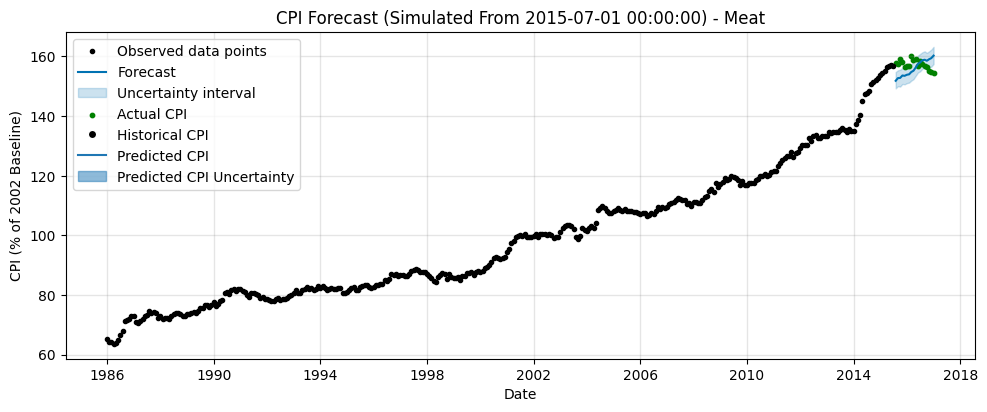

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/0bdc5rmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/ct5va66q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31363', 'data', 'file=/tmp/tmp7f_z_j0i/0bdc5rmy.json', 'init=/tmp/tmp7f_z_j0i/ct5va66q.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model521vxk8n/prophet_model-20230802195212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -5.708
mae          3.503
mape         0.022
mse         15.226
rmse         3.902
dtype: float64


19:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


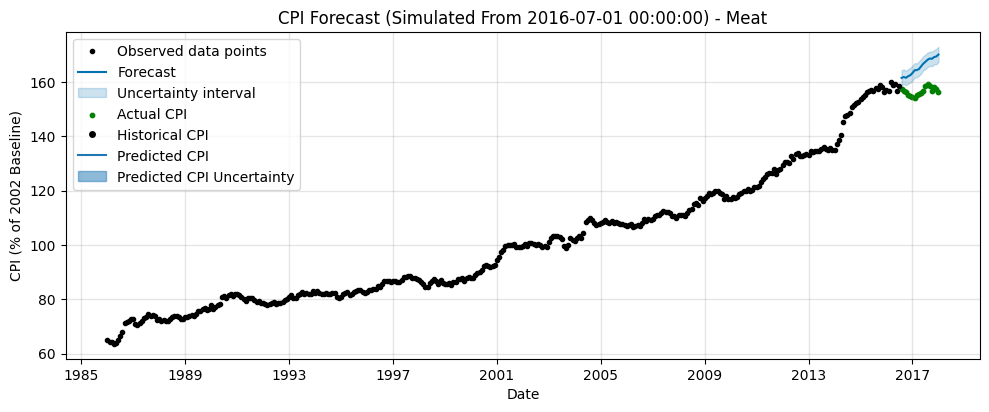

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/c_rv4vxl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/j85m9r6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66854', 'data', 'file=/tmp/tmp7f_z_j0i/c_rv4vxl.json', 'init=/tmp/tmp7f_z_j0i/j85m9r6x.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model17x5kiki/prophet_model-20230802195214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -41.032
mae          9.085
mape         0.058
mse         88.698
rmse         9.418
dtype: float64


19:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


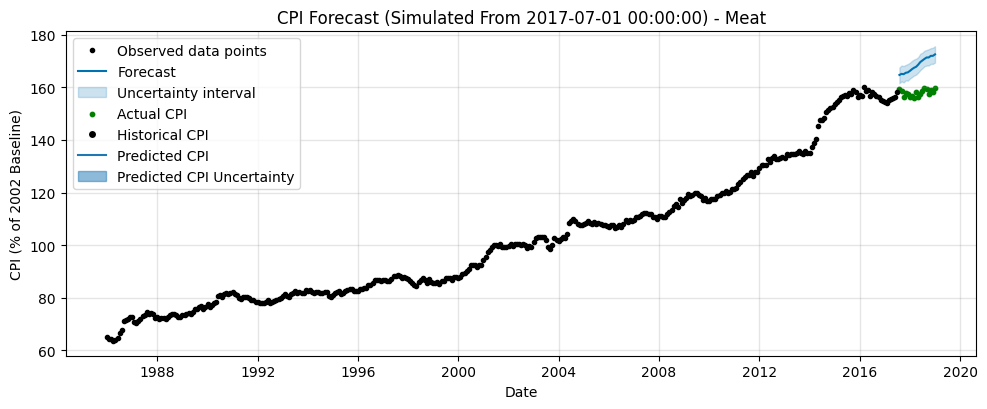

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/oyzc39r3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/q47lqimq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42633', 'data', 'file=/tmp/tmp7f_z_j0i/oyzc39r3.json', 'init=/tmp/tmp7f_z_j0i/q47lqimq.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modeltz_g820l/prophet_model-20230802195216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -79.406
mae          10.533
mape          0.067
mse         116.601
rmse         10.798
dtype: float64


19:52:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


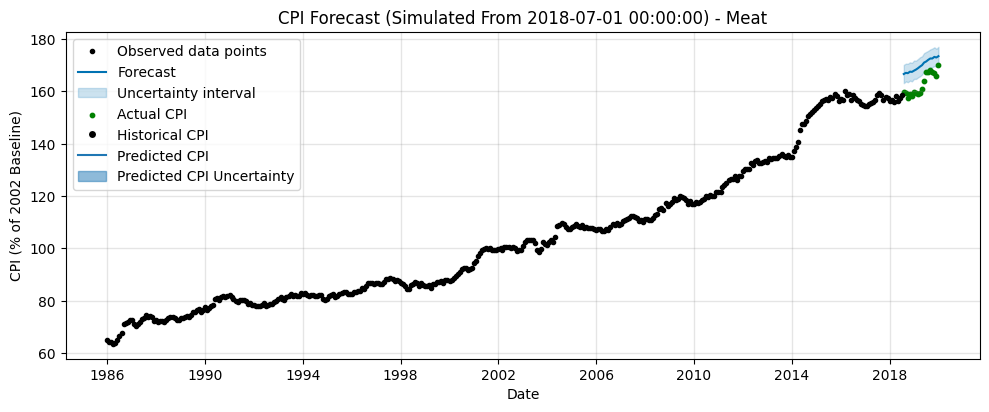

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/k2g0kalt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/cjtxojkm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90941', 'data', 'file=/tmp/tmp7f_z_j0i/k2g0kalt.json', 'init=/tmp/tmp7f_z_j0i/cjtxojkm.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model59nce7h8/prophet_model-20230802195219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -2.302
mae          7.202
mape         0.045
mse         56.183
rmse         7.496
dtype: float64


19:52:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


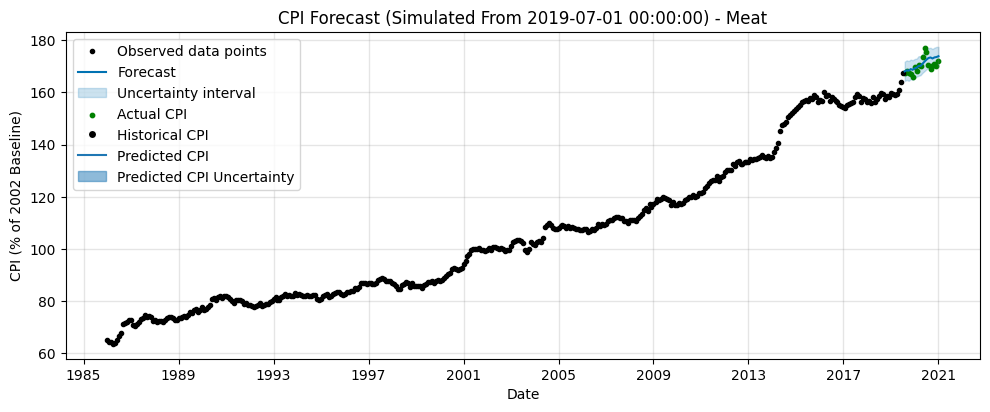

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/2t42uffl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/ed3wwcsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90412', 'data', 'file=/tmp/tmp7f_z_j0i/2t42uffl.json', 'init=/tmp/tmp7f_z_j0i/ed3wwcsv.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelgz_pq2b4/prophet_model-20230802195221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.193
mae         2.099
mape        0.012
mse         6.425
rmse        2.535
dtype: float64


19:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


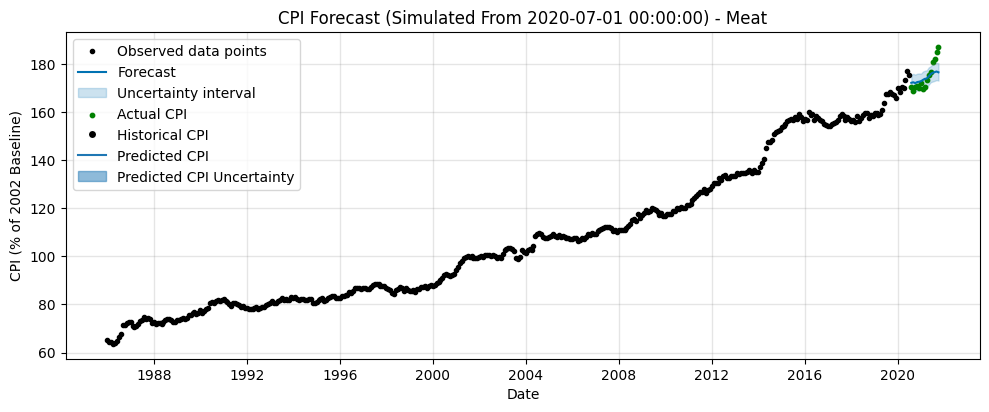

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/zcwxxc3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/yr8xc4rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15148', 'data', 'file=/tmp/tmp7f_z_j0i/zcwxxc3n.json', 'init=/tmp/tmp7f_z_j0i/yr8xc4rs.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelxuir_q8q/prophet_model-20230802195223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score     0.451
mae          3.359
mape         0.019
mse         19.031
rmse         4.362
dtype: float64


19:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


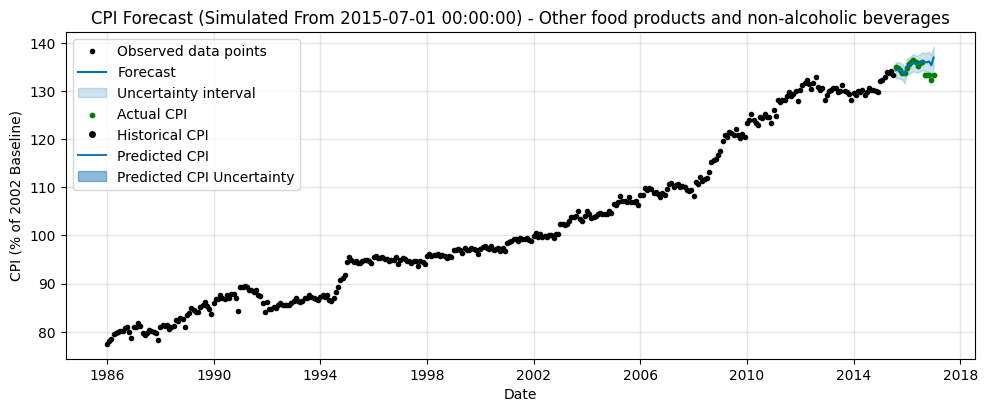

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/ge5vzxvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/1o9s1z2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19159', 'data', 'file=/tmp/tmp7f_z_j0i/ge5vzxvi.json', 'init=/tmp/tmp7f_z_j0i/1o9s1z2k.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelxrhafv8w/prophet_model-20230802195225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -0.788
mae         1.068
mape        0.008
mse         2.562
rmse        1.601
dtype: float64


19:52:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


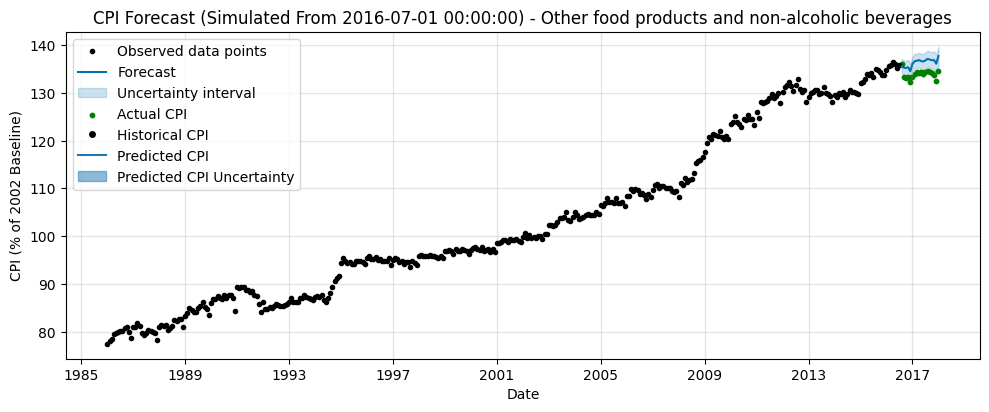

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/yh9g5sr5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/0n5gwn1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28096', 'data', 'file=/tmp/tmp7f_z_j0i/yh9g5sr5.json', 'init=/tmp/tmp7f_z_j0i/0n5gwn1o.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model279d6phq/prophet_model-20230802195227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -8.228
mae         2.480
mape        0.019
mse         6.536
rmse        2.557
dtype: float64


19:52:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


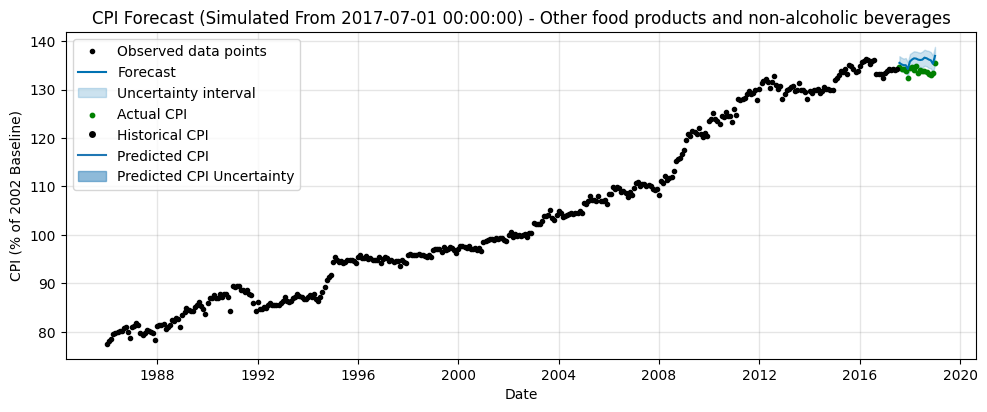

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/v6jppk_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/8msb41j8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10100', 'data', 'file=/tmp/tmp7f_z_j0i/v6jppk_8.json', 'init=/tmp/tmp7f_z_j0i/8msb41j8.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model78bcbnhf/prophet_model-20230802195230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -7.504
mae         1.909
mape        0.014
mse         4.159
rmse        2.039
dtype: float64


19:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


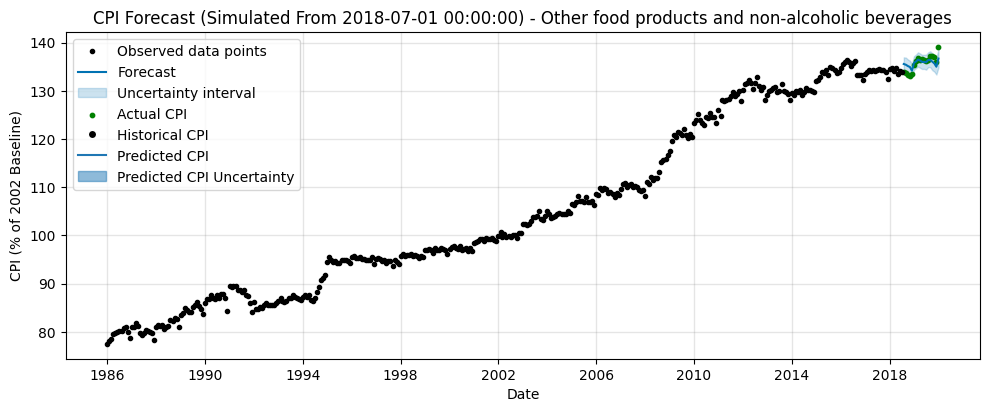

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/shczyujt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/x641zs5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48117', 'data', 'file=/tmp/tmp7f_z_j0i/shczyujt.json', 'init=/tmp/tmp7f_z_j0i/x641zs5i.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelw77airla/prophet_model-20230802195232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    0.472
mae         0.939
mape        0.007
mse         1.392
rmse        1.180
dtype: float64


19:52:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


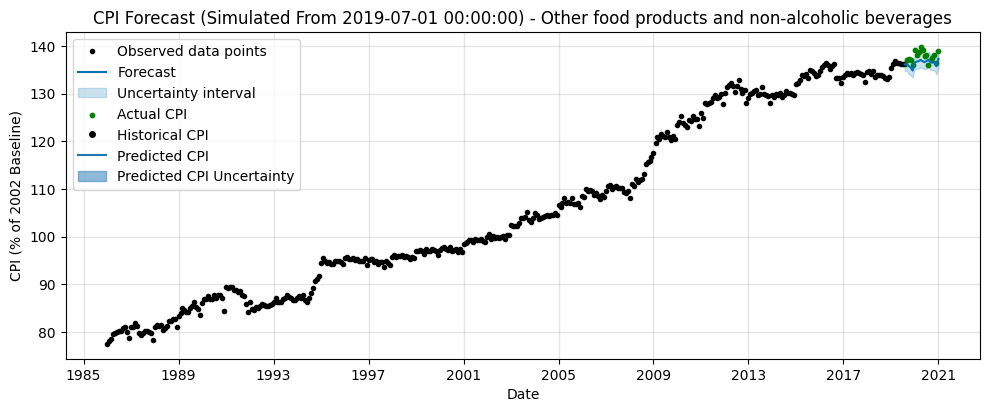

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/rvhwkn52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/j7dsk1yl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2912', 'data', 'file=/tmp/tmp7f_z_j0i/rvhwkn52.json', 'init=/tmp/tmp7f_z_j0i/j7dsk1yl.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model3sa7vwxh/prophet_model-20230802195235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score   -0.922
mae         1.385
mape        0.010
mse         2.364
rmse        1.537
dtype: float64


19:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


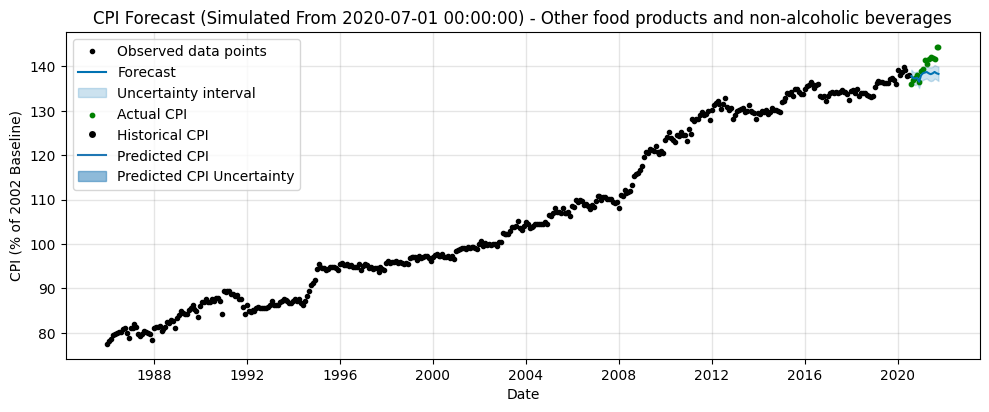

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/3wugdwzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/68pe7dij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46706', 'data', 'file=/tmp/tmp7f_z_j0i/3wugdwzu.json', 'init=/tmp/tmp7f_z_j0i/68pe7dij.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model51fadfpa/prophet_model-20230802195237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score   -0.313
mae         2.344
mape        0.017
mse         9.013
rmse        3.002
dtype: float64


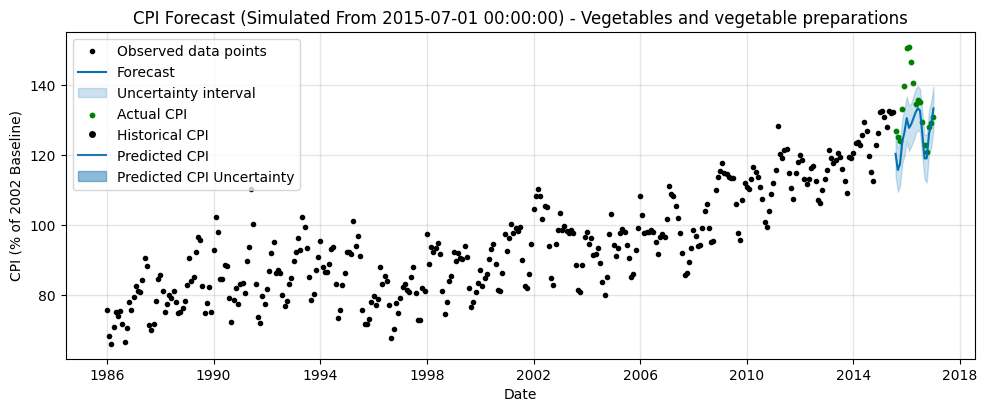

r2_score     -0.303
mae           7.606
mape          0.055
mse         102.582
rmse         10.128
dtype: float64


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/fp8edufg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/qff86p52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90163', 'data', 'file=/tmp/tmp7f_z_j0i/fp8edufg.json', 'init=/tmp/tmp7f_z_j0i/qff86p52.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_model77vq27le/prophet_model-20230802195240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


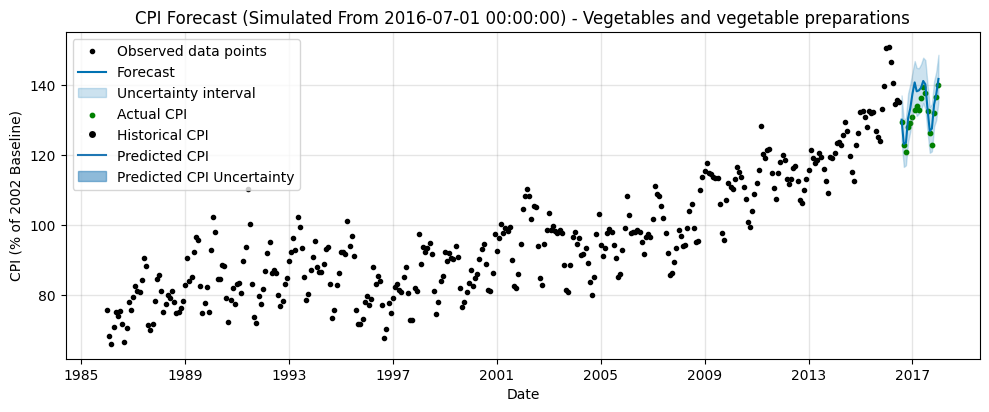

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/qwovrm6y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/rmoklzm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40449', 'data', 'file=/tmp/tmp7f_z_j0i/qwovrm6y.json', 'init=/tmp/tmp7f_z_j0i/rmoklzm6.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelymkgeozn/prophet_model-20230802195242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


r2_score     0.562
mae          2.937
mape         0.022
mse         13.200
rmse         3.633
dtype: float64


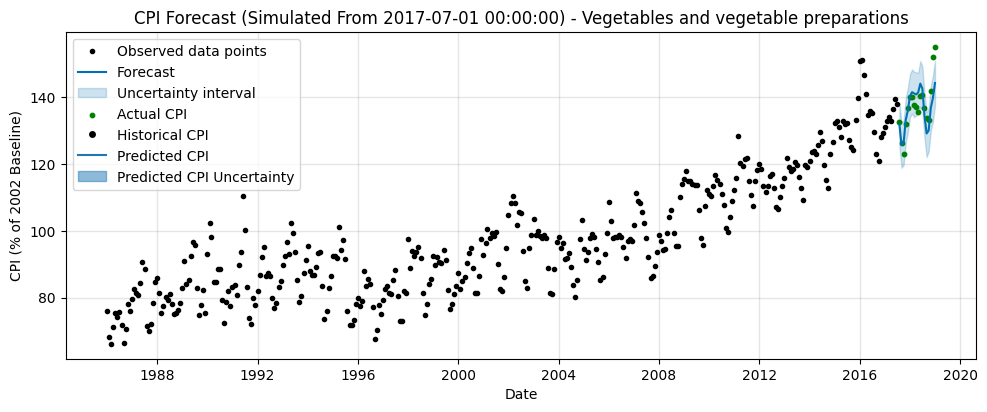

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/fmimwo_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/36yfe95k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20804', 'data', 'file=/tmp/tmp7f_z_j0i/fmimwo_l.json', 'init=/tmp/tmp7f_z_j0i/36yfe95k.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelcu8pchgy/prophet_model-20230802195244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score     0.569
mae          3.643
mape         0.026
mse         23.609
rmse         4.859
dtype: float64


19:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


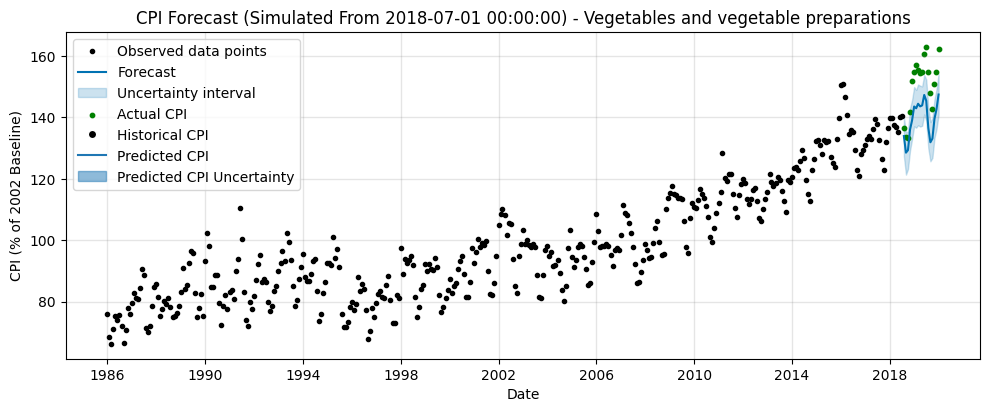

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/foz4yb_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/_152euyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70493', 'data', 'file=/tmp/tmp7f_z_j0i/foz4yb_x.json', 'init=/tmp/tmp7f_z_j0i/_152euyy.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelyejf_rd8/prophet_model-20230802195246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score     -0.758
mae          11.216
mape          0.073
mse         144.866
rmse         12.036
dtype: float64


19:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


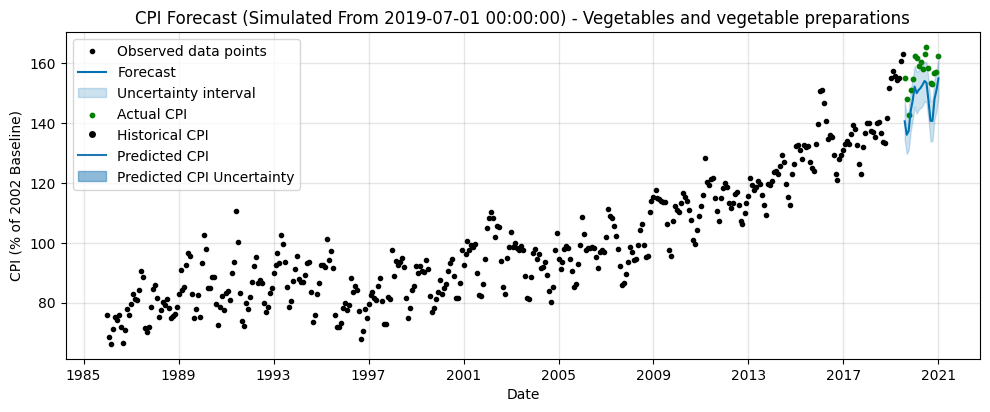

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/0r8xsa0e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7f_z_j0i/3ow2ba9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49047', 'data', 'file=/tmp/tmp7f_z_j0i/0r8xsa0e.json', 'init=/tmp/tmp7f_z_j0i/3ow2ba9d.json', 'output', 'file=/tmp/tmp7f_z_j0i/prophet_modelcz1akvxm/prophet_model-20230802195248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


r2_score    -2.051
mae          9.434
mape         0.060
mse         95.997
rmse         9.798
dtype: float64


19:52:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


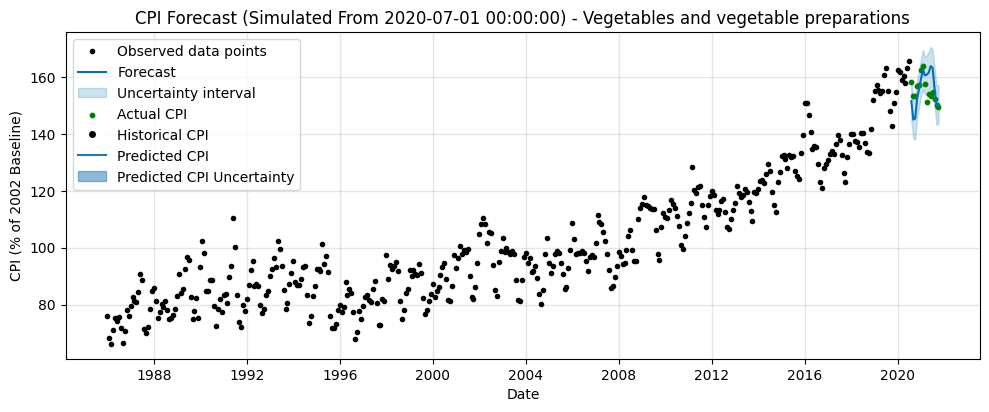

r2_score    -1.252
mae          5.115
mape         0.033
mse         37.234
rmse         6.102
dtype: float64


In [18]:
all_valid_metrics = {}
all_forecasts = {}

for food_category in foodprice_categories:

    """
    Iterate over each of the food price categories.
    """

    annual_valid_metrics = {}
    annual_forecasts = {}

    for date in cutoff_dates:

        """
        Iterate over each of the cutoff dates.
        """

        train_dates = sim_train_dates[date]
        valid_dates = sim_valid_dates[date]

        model, valid_forecast, valid_metrics = fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates)
        valid_actual = get_prophet_df(foodprice_df, food_category, valid_dates)

        plot_valid_forecast(model, food_category, date, valid_forecast, valid_actual)
        valid_metrics_series = pd.Series(valid_metrics)
        print(valid_metrics_series)

        annual_valid_metrics[date] = valid_metrics_series
        annual_forecasts[date] = valid_forecast.yhat

    all_valid_metrics[food_category] = annual_valid_metrics
    all_forecasts[food_category] = annual_forecasts

### View Raw Evaluation Metrics

View all evaluation metrics for one target category, over each of the cutoff dates.

In [19]:
food_category = 'Vegetables and vegetable preparations'
pd.DataFrame(all_valid_metrics[food_category]).T

r2_score     mae   mape      mse    rmse
2015-07-01    -0.303   7.606  0.055  102.582  10.128
2016-07-01     0.562   2.937  0.022   13.200   3.633
2017-07-01     0.569   3.643  0.026   23.609   4.859
2018-07-01    -0.758  11.216  0.073  144.866  12.036
2019-07-01    -2.051   9.434  0.060   95.997   9.798
2020-07-01    -1.252   5.115  0.033   37.234   6.102

### Collect Mean Validation Metrics Over Cutoff Dates and Save to File

In [20]:
mean_valid_metrics = {}
for food_category, valid_scores in all_valid_metrics.items():
    mean_valid_metrics[food_category] = pd.DataFrame(valid_scores).mean(axis=1)

mean_valid_metrics_df = pd.DataFrame(mean_valid_metrics).T
mean_valid_metrics_df.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_valid_metrics_df

r2_score    mae   mape  \
Bakery and cereal products (excluding baby food)   -13.166  4.162  0.027   
Dairy products and eggs                            -10.450  4.284  0.031   
Fish, seafood and other marine products             -1.678  2.684  0.019   
Food purchased from restaurants                     -0.362  1.877  0.012   
Food                                                -1.350  2.037  0.014   
Fruit, fruit preparations and nuts                  -1.879  4.718  0.035   
Meat                                               -21.301  5.963  0.037   
Other food products and non-alcoholic beverages     -2.881  1.687  0.012   
Vegetables and vegetable preparations               -0.539  6.658  0.045   

                                                     mse   rmse  
Bakery and cereal products (excluding baby food)  26.431  4.546  
Dairy products and eggs                           24.647  4.594  
Fish, seafood and other marine products           10.310  3.045  
Food purchased from restaurants                    5.355  2.002  
Food                                               5.373  2.210  
Fruit, fruit preparations and nuts                32.961  5.405  
Meat                                              50.361  6.418  
Other food products and non-alcoholic beverages    4.338  1.986  
Vegetables and vegetable preparations             69.581  7.759

## Save Validation Forecasts to File (Optional, For Ensembling)

In [21]:
date_forecasts = {}
for date in cutoff_dates:
    valid_dates = sim_valid_dates[date]
    food_forecasts = {}
    for food_category in foodprice_categories:
        food_forecasts[food_category] = all_forecasts[food_category][date]
    date_forecasts[date] = pd.DataFrame(food_forecasts)
    date_forecasts[date] = date_forecasts[date].set_index(pd.DatetimeIndex(valid_dates))
    date_forecasts[date].to_csv(f"{output_path}/forecasts_{date}.csv")